In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [174]:
data = pd.read_csv(r'Ames_Housing_Sales.csv')

In [98]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856.0,854.0,0.0,None,3,1Fam,TA,No,706.0,0.0,...,0.0,Pave,8,856.0,AllPub,0.0,2003,2003,2008,208500.0
1,1262.0,0.0,0.0,None,3,1Fam,TA,Gd,978.0,0.0,...,0.0,Pave,6,1262.0,AllPub,298.0,1976,1976,2007,181500.0
2,920.0,866.0,0.0,None,3,1Fam,TA,Mn,486.0,0.0,...,0.0,Pave,6,920.0,AllPub,0.0,2001,2002,2008,223500.0
3,961.0,756.0,0.0,None,3,1Fam,Gd,No,216.0,0.0,...,0.0,Pave,7,756.0,AllPub,0.0,1915,1970,2006,140000.0
4,1145.0,1053.0,0.0,None,4,1Fam,TA,Av,655.0,0.0,...,0.0,Pave,9,1145.0,AllPub,192.0,2000,2000,2008,250000.0


In [99]:
categorical_columns = data.columns[data.dtypes == np.object]

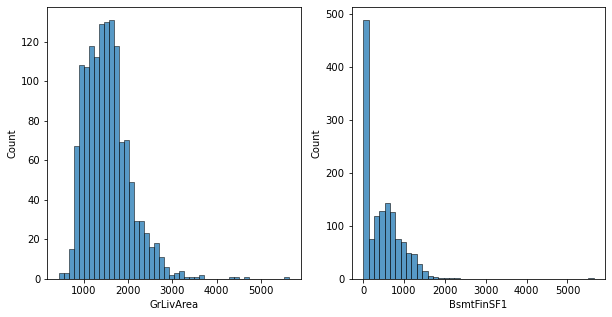

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=data, x='GrLivArea', ax=ax[0])
sns.histplot(data=data, x='BsmtFinSF1', ax=ax[1])
plt.show()

In [101]:
def outlier_removal(column, data):
    Q3 = data[column].quantile(0.75)
    Q1 = data[column].quantile(0.25)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    data.drop([data[(data[column] < lower) | (data[column] > upper)].index][0].to_list(), axis=0, inplace=True)
    

In [102]:
outlier_removal('GrLivArea', data)

In [103]:
from scipy.stats.mstats import normaltest

In [104]:
print(normaltest(data.SalePrice))
print(normaltest(data.SalePrice.apply(np.log1p)))
print(normaltest(data.SalePrice.apply(np.sqrt)))

NormaltestResult(statistic=356.9926153382572, pvalue=3.0202197221135565e-78)
NormaltestResult(statistic=12.13631366965664, pvalue=0.002315437012808391)
NormaltestResult(statistic=129.7963718152397, pvalue=6.532448202672712e-29)


* $H_{0}$ : Data is normally distributed
* $H_{A}$ : Data is not normally distributed
* Notice all the transformations have a p-value less than 0.05 which implies we can reject the null
* we need a transformation resulting in a higher p-value

In [105]:
from scipy.stats import boxcox, yeojohnson, probplot, norm

In [106]:
new_SalePrice, best_lambda = boxcox(data.SalePrice)

In [107]:
print(normaltest(new_SalePrice))

NormaltestResult(statistic=11.579358286819765, pvalue=0.0030589635075819405)


In [108]:
new_SalePrice, best_lambda =yeojohnson(data.SalePrice)

In [109]:
print(normaltest(new_SalePrice))

NormaltestResult(statistic=11.57910007721828, pvalue=0.0030593584599506404)


* Since the p-values of boxcox and yeojohnson were really close to 0.05 we will consider one of these

In [110]:
data.SalePrice, best_lambda = boxcox(data.SalePrice)

<function matplotlib.pyplot.show(close=None, block=None)>

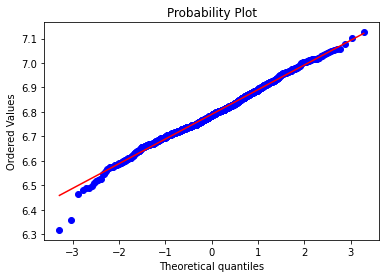

In [111]:
probplot(data.SalePrice, dist=norm, plot=plt)
plt.show

* There are still outliers present they may or may not be useful to the model.

### Data Preprocessing
 * Now Since there are 80 features and lot of them are object type, It is hard to classify them as ordinal and nominal. 
 * You either have to go through all the categorical columns and get an idea or just one hot encode all the categorical.

In [112]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [113]:
oh = OneHotEncoder()
one_hot_data = oh.fit_transform(data[categorical_columns]).toarray()
col_names = []
for i in categorical_columns:
    for j in range(data[i].nunique()):
        col_names.append(str(i)+'_'+str(j))

In [114]:
new_data = data.drop(categorical_columns, axis=1).reset_index()

In [115]:
new_data.drop('index', axis=1, inplace=True)

In [116]:
one_hot_data = pd.DataFrame(one_hot_data, columns=col_names)

In [117]:
data = pd.concat([new_data, one_hot_data], axis=1)

In [118]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector

In [119]:
X = data.drop('SalePrice', axis=1)
y = data.SalePrice

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [133]:
SKB = SelectKBest(f_regression, k=100)
RFE = RFECV(estimator=LinearRegression(), n_jobs=-1, step=1, cv=6, min_features_to_select=75, scoring='neg_mean_squared_error')
SFS = SequentialFeatureSelector(estimator=LinearRegression(), k_features=100, forward=True, scoring='neg_mean_squared_error', n_jobs=-1)

In [134]:
SKB = SKB.fit(X_train, y_train)
RFE = RFE.fit(X_train, y_train)
SFS = SFS.fit(X_train, y_train)

In [135]:
best_features_dict = {'Kbest': X_train.columns[SKB.get_support()], 'RFE':X_train.columns[RFE.support_], 'SFS': list(SFS.k_feature_names_)}

In [158]:
scores_list = []
for i in best_features_dict:
    X_train_best = X_train[best_features_dict[i]]
    X_test_best = X_test[best_features_dict[i]]
    Rid = RidgeCV(alphas=[0.001, 0.1, 0.01, 1.5, 2.8, 6.9, 21, 4.5], cv=6, scoring='neg_mean_squared_error')
    Rid = Rid.fit(X_train_best, y_train)
    preds = Rid.predict(X_test_best)
    scores_list.append(pd.DataFrame({i:r2_score(y_test, preds), 'model' + '_' +str(i):Rid}, index=range(1)))


In [159]:
scores_frame = pd.concat(scores_list, axis=1)

In [160]:
scores_frame.T

,0
Kbest,0.896839
model_Kbest,"RidgeCV(alphas=array([1.0e-03, 1.0e-01, 1.0e-0..."
RFE,0.914667
model_RFE,"RidgeCV(alphas=array([1.0e-03, 1.0e-01, 1.0e-0..."
SFS,0.90673
model_SFS,"RidgeCV(alphas=array([1.0e-03, 1.0e-01, 1.0e-0..."


* Here RFE used all the features, SFS used a subset but still did a pretty good job 

In [142]:
from scipy.special import inv_boxcox

In [169]:
best_model = scores_frame['model_RFE'][0]

In [170]:
final_preds = best_model.predict(X_test)

In [178]:
r2_score(inv_boxcox(y_test, best_lambda), inv_boxcox(final_preds, best_lambda)) # Inverse the transformations to get the original house prices

0.9140313139349624

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

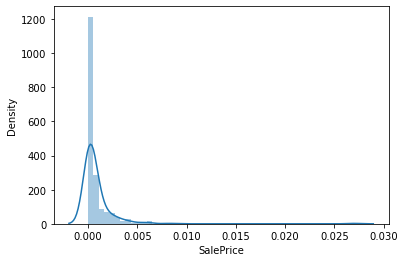

In [183]:
sns.distplot((y_test - final_preds)**2)